Written by Joao Rodrigues

June 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator and calculates the steady-state populations and a function of increasing pump power. The idea is to show the occurence of BEC phase transition, and eventually other phase transitions.

Note: All parameters are defined in SI units


In [127]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [128]:
grid_size = 60.0*1e-6      # meters
grid_delta = 2*1e-6      # meters 
L0 = 1.98*1e-6              # meters 
q = 10                     # longitudinal mode number
n = 2.4
#n=1.43
n_modes = 50
feature_RoC = 0.1   # meters
feature_depth = 0.279*1e-6 # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_elliptical(RoC=feature_RoC, depth=feature_depth, anistropy_factor=1.001)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()
print(lambdas)

[9.50266682e-07 9.50134698e-07 9.50134569e-07 9.50005249e-07
 9.50004995e-07 9.50002622e-07 9.49878409e-07 9.49878037e-07
 9.49873208e-07 9.49873084e-07 9.49754264e-07 9.49753778e-07
 9.49746404e-07 9.49746161e-07 9.49743706e-07 9.49632906e-07
 9.49632313e-07 9.49622293e-07 9.49621936e-07 9.49616936e-07
 9.49616817e-07 9.49514444e-07 9.49513750e-07 9.49500969e-07
 9.49500506e-07 9.49492859e-07 9.49492627e-07 9.49490081e-07
 9.49398998e-07 9.49398210e-07 9.49382540e-07 9.49381975e-07
 9.49371568e-07 9.49371229e-07 9.49366037e-07 9.49365924e-07
 9.49286708e-07 9.49285834e-07 9.49267126e-07 9.49266468e-07
 9.49253171e-07 9.49252731e-07 9.49244779e-07 9.49244559e-07
 9.49241912e-07 9.49177735e-07 9.49176784e-07 9.49154867e-07
 9.49154123e-07 9.49137788e-07]


## Defines the cavity pump profile

In [129]:
pump_width = 10*1e-6       # meters

X, Y = cavity_modes.get_cavity_grid()
pump_base = np.exp(-((X)**2+Y**2) / pump_width**2)
pump = 1*(pump_base/np.sum(pump_base))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

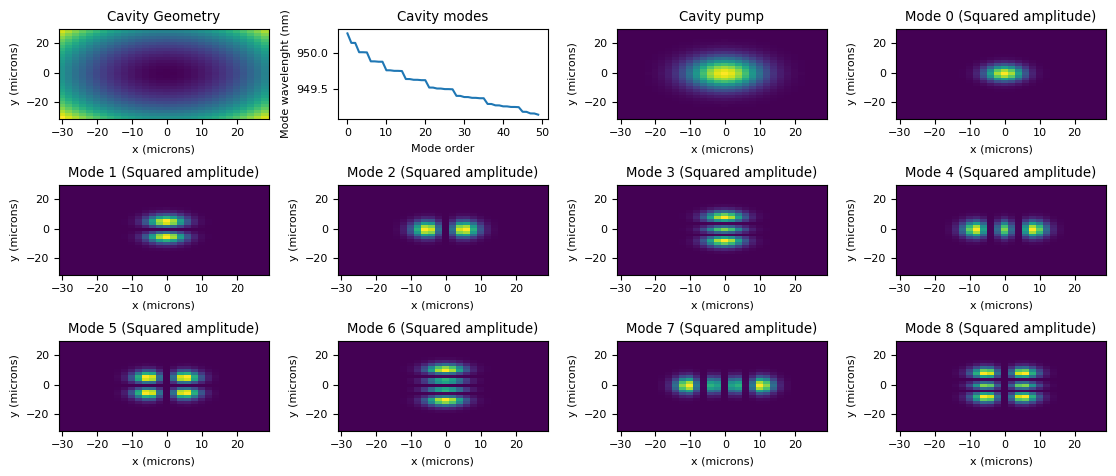

In [130]:
cavity_modes.plot_cavity(start_mode=0)


## Calculates emission and absorption rates from experimental data

C:\Users\natak\OneDrive - Imperial College London\Documents\University\Year 4\MSci Project-r018104\PyPBEC_Semiconductor\PyPBEC\OpticalMedium.py:197: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  abs_sum, _ = quad(absorption_rates_func, 900, 969, args=(mode,))
C:\Users\natak\OneDrive - Imperial College London\Documents\University\Year 4\MSci Project-r018104\PyPBEC_Semiconductor\PyPBEC\OpticalMedium.py:198: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order 

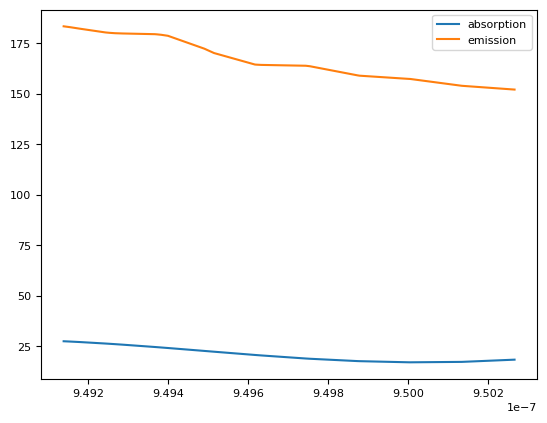

[18.36668542 17.26611257 17.2654613  17.05349591 17.05390423 17.05787174
 17.62228859 17.62498106 17.66037853 17.66130225 18.81479341 18.82054837
 18.90883344 18.91177421 18.94156784 20.453222   20.46203334 20.61184068
 20.61719798 20.69258895 20.69438586 22.29944409 22.31055698 22.51548754
 22.52292234 22.64560793 22.64933062 22.69016741 24.13297479 24.14515434
 24.38600384 24.39461683 24.55273685 24.55786453 24.63615164 24.63785362
 25.77427867 25.78610429 26.03501591 26.04361481 26.21504038 26.22063295
 26.32084941 26.32360144 26.35655817 27.09233008 27.10225124 27.32201812
 27.32917966 27.48120437]


In [131]:
dye_concentration = 2.0               # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
R6G = OpticalMedium(optical_medium="InGaAs_QW")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, mode=17)

#R6G = OpticalMedium(optical_medium="Rhodamine6G")
#absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

plt.plot(lambdas, absorption_rates, label='absorption')
plt.plot(lambdas, emission_rates, label='emission')
plt.legend()
plt.show()

print(absorption_rates)

#### Normalizes the rates, for better numerical performance

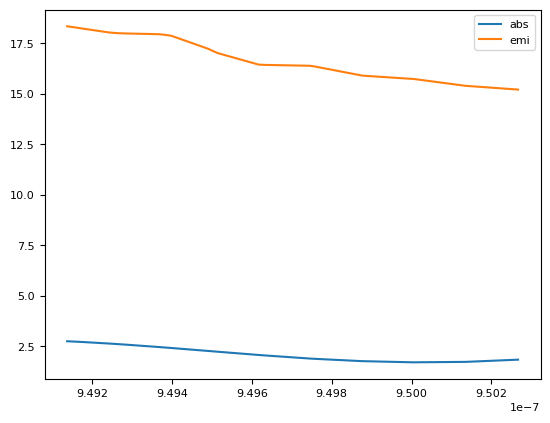

In [132]:
#cavity_loss_rate = 1.0/(10*1e-12)     # in s^-1
cavity_loss_rate = 10     # in s^-1



cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

plt.plot(lambdas, absorption_rates, label = 'abs')

plt.plot(lambdas, emission_rates, label = 'emi')
plt.legend()
plt.show()

## Defines a cavity

In [133]:
#Gamma_down = cavity_loss_rate

Gamma_down = 100

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=Gamma_down*np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

print(molecular_population)
# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)


[4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535 4769535
 4769535 4769535 4769535 4769535 4769535 4769535 47

## Creates the array of pump values

In [134]:
pump_value_min = 100.0
pump_value_max = 1000000.0
n_pump_values = 30

delta_p = (pump_value_max/pump_value_min)**(1/n_pump_values)-1
pumps = [(1+delta_p)**i*pump_value_min for i in range(0, n_pump_values)]

## Solves the mean-field steady-state

In [135]:
from PyPBEC.Solver import SteadyState
from tqdm import tqdm
populations = list()
for value in tqdm(pumps):
    # loads the pump onto the cavity object
    pump = value*(pump_base/np.sum(pump_base))
    cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
    
    # Steady-state solver
    solver_steadystate = SteadyState(cavity_obj=cavity, ANNEALING=False)
    # Defines the initial guess
    if value==pumps[0]:
        solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(cavity.M)))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(cavity.J)))  
    else:
        solver_steadystate.set_initial_photons(initial_photons=np.array(solved_cavity_steadystate.photons[-1]))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(solved_cavity_steadystate.emols[-1])) 
    
    # Calls the solver
    solved_cavity_steadystate = solver_steadystate.solve()
    
    # Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
    mode_degeneracy = np.array([j for j in range(0, n_modes) for i in range(0, j)][0:n_modes])
    steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
        for mode_number in list(set(list(mode_degeneracy)))]
    steady_state_photon_population = np.transpose(np.array(steady_state_photon_population))
    
    # Appends
    populations.append(steady_state_photon_population)
populations = np.array(populations)

100%|██████████| 30/30 [08:39<00:00, 17.31s/it]


## Plots the results

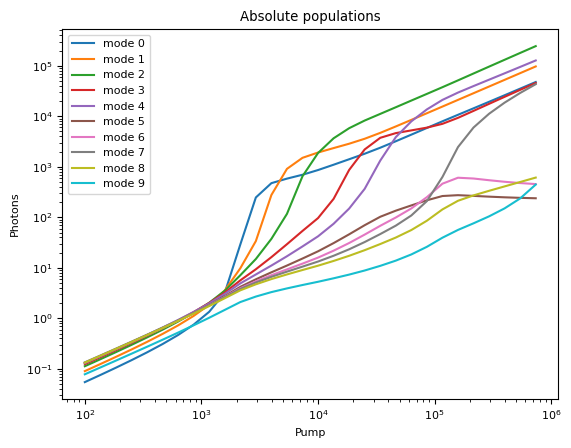

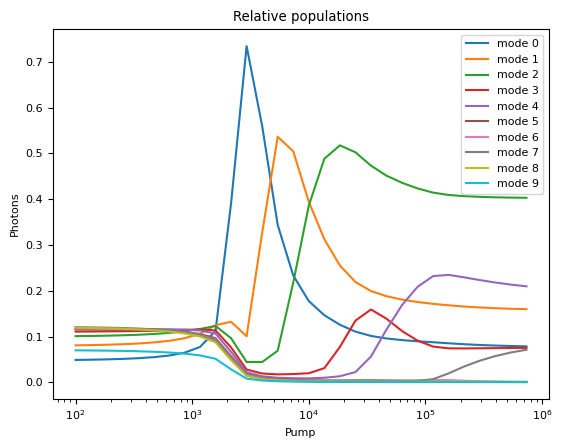

In [136]:
populations = np.squeeze(populations)

[plt.plot(pumps, populations[:,i], label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.yscale("log")
plt.title("Absolute populations")
plt.show()

[plt.plot(pumps, populations[:,i]/np.sum(populations,1), label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.title("Relative populations")
plt.show()

In [137]:
print(populations)

[[5.46697256e-02 9.02447480e-02 1.12803040e-01 1.23808692e-01
  1.30244798e-01 1.29250265e-01 1.31612389e-01 1.34564043e-01
  1.33186888e-01 7.80939469e-02]
 [7.56691899e-02 1.24497865e-01 1.55201499e-01 1.69934666e-01
  1.78450540e-01 1.76798094e-01 1.79848769e-01 1.83750582e-01
  1.81736162e-01 1.06568853e-01]
 [1.05471933e-01 1.72725450e-01 2.14514519e-01 2.34092176e-01
  2.45216631e-01 2.42396681e-01 2.46238956e-01 2.51333628e-01
  2.48327219e-01 1.45632329e-01]
 [1.48494607e-01 2.41561666e-01 2.98407348e-01 3.24108477e-01
  3.38340215e-01 3.33398559e-01 3.38036451e-01 3.44562158e-01
  3.39967060e-01 1.99402274e-01]
 [2.12150124e-01 3.41748603e-01 4.18928355e-01 4.51956264e-01
  4.69505195e-01 4.60610761e-01 4.65775579e-01 4.73873393e-01
  4.66654055e-01 2.73758816e-01]
 [3.09842694e-01 4.91775060e-01 5.95994444e-01 6.36713656e-01
  6.56822021e-01 6.40356093e-01 6.45113201e-01 6.54601384e-01
  6.42900930e-01 3.77244163e-01]
 [4.68487161e-01 7.26258219e-01 8.64868299e-01 9.10505404e